## Analyzing raw OONI data, a case study

The goal of this notebook is to explain some of the common workflows that can be adopted when performing analysis of OONI data. This will be done within the context of a specific case study and will focus on the analysis of [Web Connectivity](https://github.com/ooni/spec/blob/master/nettests/ts-017-web-connectivity.md) data.

We will be focusing on answering the following 2 research questions:
- What domains present signs of blocking in Russia between the 23rd of February and the 17th of March 2022?
- How does the blocking vary from ISP to ISP?

It can be useful, before you dive into more extensive analysis, to get a sense for what you are likely to find in the data by using the [Measurement Aggregation Toolkit](https://explorer.ooni.org/experimental/mat). For example you can pick a certain country and plot the [anomalies with a per-domain breakdown](https://explorer.ooni.org/experimental/mat?probe_cc=RU&test_name=web_connectivity&category_code=GRP&since=2022-03-09&until=2022-04-09&axis_x=measurement_start_day&axis_y=domain) (it's often helpful to limit the domains to categories that are most relevant, so as to focus on interesting insight).

In doing so, you will understand if there is something interesting to investigate in the country in question at all and will also help in identifying some examples of interesting sites that you might want to further investigate.

It's also posisble to use the same API the MAT relies on, for downloading the anomaly,confirmed,failure,ok breakdowns to be used in your own analysis or plotting tooling. Depending on the type of analysis you need to do, this might be sufficient, however keep in mind that the anomaly flag is [suscpetible to false positives](https://ooni.org/support/faq/#why-do-false-positives-occur).

It's also useful, while you are performing the analysis, to refer to OONI Explorer to inspect the measurements that present anomalies, so as to be able to identify patterns that you can use to further improve your detection heuristics.

At a high level the workflow we are going to look at is the following:

![High level overview](https://kroki.io/blockdiag/svg/eNqVj7EKwkAMhnefIpM3CUVxEgVF3FxcHMQh9mINXpNyplQQ392ednAR6RjyfX_yn4LmV89YwGMA4NbaSFD0sFvuwaOhg9EC3IbQ6khAd4uYG6vAEEoWLvmGafxgqxTGUgCKqH0ttig1hlavgkbs_HNLUqwii4Eno3eum6U3evA_D_cNOjTs7TKfZNkxmf8rd8J42grPF1OgcX0=)

### Downloading the data

Once you have gotten a feel for the data, it's time to download the raw dataset.

We offer a tool called oonidata (that's currently in BETA and be sure you have at least v0.2.3), which can be installed by running:
```
pip install oonidata
```

To download all OONI data for this example notebook, run the following command (you should have at least 38GB on disk):
```
oonidata sync --start-day 2022-02-23 --end-day 2022-03-17 --probe-cc RU --test-name web_connectivity --output-dir ooni-russia-data
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from urllib.parse import urlencode, quote, urlparse

from tqdm import tqdm
tqdm.pandas()

### OONI Explorer utility functions

Below are a couple of useful utility functions when dealing with measurements. They take a dataframe row and return (or print) the OONI Explorer URL. This is useful to get a link to OONI explorer to more easily inspect the raw measurement to better understand what is going on.

In [2]:
def get_explorer_url(e):
    query = ''
    if 'input' in e.keys() and e['input']:
        query = '?input={}'.format(quote(e['input'], safe=''))
    return 'https://explorer.ooni.org/measurement/{}{}'.format(e['report_id'], query)
    
def print_explorer_url(e):
    print(get_explorer_url(e))

### Extracting metadata from raw measurements

The OONI raw data is very rich, but for most analysis use-cases you just need a subset of the fields or some value that is derived from them.

Below are functions that will extract all the metadata we care about from the web_connectivity test.

In [3]:
import requests
from base64 import b64decode
import hashlib
import json
import re

def get_raw_measurement(row):
    r = requests.get("https://api.ooni.io/api/v1/measurement_meta", params={
        'report_id':row['report_id'],
        'input': row['input'],
        'full': True
    })
    j = r.json()
    return json.loads(j['raw_measurement'])

def get_resolved_ips(msmt):
    queries = msmt['test_keys'].get('queries', [])
    if not queries:
        return ''
    answers = queries[0].get('answers', [])
    if not answers:
        return []
    
    ip_list = []
    for a in answers:
        ip = a.get('ipv4', '')
        if ip:
            ip_list.append(ip)
    return ip_list

def get_control_failure(msmt):
    if 'test_keys' not in msmt:
        return 'missing_test_keys'
    return msmt['test_keys']['control_failure']

def get_test_keys_blocking(msmt):
    return str(msmt['test_keys']['blocking'])

def get_http_experiment_failure(msmt):
    return str(msmt['test_keys']['http_experiment_failure'])

def get_resolver_info(msmt):
    return {
        'resolver_ip': msmt.get('resolver_ip', ''),
        'resolver_asn': msmt.get('resolver_asn', ''),
        'resolver_network_name': msmt.get('resolver_network_name', '')
    }

def get_network_events(msmt):
    return msmt['test_keys'].get('network_events', [])

def get_tcp_connect(msmt):
    return msmt['test_keys'].get('tcp_connect', [])

def decode_body(body):
    if body is None:
        return ''
    if isinstance(body, dict):
        raw_body = b64decode(body['data'])
        try:
            return raw_body.decode('utf-8')
        except:
            return raw_body
    return body

def get_last_response_body(msmt):
    try:
        # The requests/response list sorts them from the newest to the oldest, 
        # hence the first item in the list is the last response we received.
        body = msmt['test_keys']['requests'][0]['response']['body']
        return decode_body(body)
    except (KeyError, TypeError, IndexError):
        return ''

TITLE_REGEXP = re.compile("<title.*?>(.*?)</title>", re.IGNORECASE | re.DOTALL)
# Doesn't take into account ordering
META_TITLE_REGEXP = re.compile("<meta.*?property=\"og:title\".*?content=\"(.*?)\"", re.IGNORECASE | re.DOTALL)

def get_http_title(msmt):
    body = get_last_response_body(msmt)
    # If the body is not a str object, it means it's binary (or an encoding we could not detect). 
    # No point in trying to extract the title.
    # Handling it like this is not very clean or nice.
    if not isinstance(body, str):
        return ''

    m = TITLE_REGEXP.search(body, re.IGNORECASE | re.DOTALL)
    if m:
        return m.group(1)
    return ''

    return extract_title(get_last_response_body(msmt))

def get_meta_http_title(msmt):
    body = get_last_response_body(msmt)
    if not isinstance(body, str):
        return ''

    m = META_TITLE_REGEXP.search(body, re.IGNORECASE | re.DOTALL)
    if m:
        return m.group(1)
    return ''

def get_http_body_hash(msmt):
    body = get_last_response_body(msmt)
    if body == '':
        return ''
    if isinstance(body, str):
        # We need the content of the body to be binary.
        body = body.encode('utf-8')
    return hashlib.md5(body[:2048]).hexdigest()

def base_metadata(msmt):
    base_keys = [
        'input',
        'measurement_start_time',
        'probe_asn',
        'probe_cc',
        'probe_network_name',
        'report_id',
        'resolver_asn',
        'resolver_ip',
        'resolver_network_name',
        'software_name',
        'software_version',
        'test_name',
        'test_runtime',
        'test_version'
    ]
    base_metadata = {}
    for k in base_keys:
        base_metadata[k] = msmt.get(k, '')
    annotations = msmt.pop('annotations')
    base_metadata['network_type'] = annotations.get('network_type', 'unknown')
    base_metadata['origin'] = annotations.get('origin', 'unknown')
    base_metadata['platform'] = annotations.get('platform', 'unknown')
    return base_metadata

In [4]:
def get_measurement_meta(msmt):
    m = base_metadata(msmt)
    m.update(get_resolver_info(msmt))
    m.update({
        'dns_resolved_ips': get_resolved_ips(msmt),
        'network_events': get_network_events(msmt),
        'control_failure': get_control_failure(msmt),
        'control_measurement': msmt['test_keys']['control'],
        'blocking': get_test_keys_blocking(msmt),
        'http_experiment_failure': get_http_experiment_failure(msmt),
        'dns_experiment_failure': str(msmt['test_keys']['dns_experiment_failure']),
        'http_title': get_http_title(msmt),
        'http_meta_title': get_meta_http_title(msmt),
        'http_body_md5': get_http_body_hash(msmt),
        'tcp_connect': get_tcp_connect(msmt),
    })
    return m

### Parsing raw files on disk, filtering and transforming them

Below are functions that will list the files on disk, given a search query, and return an iterator of the raw measurement dict.

These functions are then called by either `msmt_to_csv` or `get_msmt_df`, which write the processed data to a CSV file or load it in memory as a pandas DataFrame respectively.

It's generally recommended, when you are dealing with very large datasets, to write the minimised form of the data to a file on disk so that you don't have to re-parse everything if your notebook crashes.

In this example the compressed raw dataset of ~38GB is minimised to a 7.7GB CSV file. The minimisation process took 1.5h on a pretty fast machine.

Once the data is minimised, loading it back in memory from the 7.7GB file is fast.

In [6]:
from tqdm import tqdm
from pathlib import Path
import gzip
import ujson

data_dir = Path('ooni-russia-data')

def iter_msmts(fp):
    with gzip.open(fp) as in_file:
        yield from [ujson.loads(line) for line in in_file]
            
def iter_jsonl_paths(query):
    for p in data_dir.glob('*/*/*/*'):
        ts, cc, tn = p.name.split('_')
        tn = tn.split('.')[0]
        ts = datetime.strptime(ts, '%Y%m%d%H')
        if query.get('probe_cc') and cc != query['probe_cc']:
            continue
        if query.get('test_name') and tn != query['test_name'].replace('_', ''):
            continue
        if query.get('since') and parse_date(query['since']) >= ts:
            continue
        if query.get('until') and parse_date(query['until']) <= ts:
            continue
        yield p
        
def iter_raw_measurements(query):
    path_list = list(iter_jsonl_paths(query))
    print(f"processing {len(path_list)}")
    for fp in tqdm(path_list):
        for msmt in iter_msmts(fp):
            if query.get('probe_asn') and msmt['probe_asn'] != query['probe_asn']:
                continue
            if query.get('domain'):
                domain = urlparse(msmt['input']).netloc
                if domain != query['domain']:
                    continue
            yield msmt

In [7]:
import csv

def msmt_to_csv(query, output_file="output.csv"):
    with open(output_file, 'w') as output_file:
        csv_writer = None
        for msmt in iter_raw_measurements(query):
            msmt_meta = get_measurement_meta(msmt)
            if csv_writer is None:
                fieldnames = msmt_meta.keys()
                csv_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
                csv_writer.writeheader()
            csv_writer.writerow(msmt_meta)

In [8]:
def get_msmt_df(query):
    msmt_list = []
    for msmt in iter_raw_measurements(query):
        mdf = pd.DataFrame([get_measurement_meta(msmt)])
        msmt_list.append(mdf)
    return pd.concat(msmt_list, ignore_index=True)

Here we do the actual conversion to CSV.

In [ ]:
msmt_to_csv({
    'since': '2022-02-23',
    'until': '2022-03-17',
    'probe_cc': 'RU',
    'test_name': 'web_connectivity'
}, output_file="ooni-data-russia.csv")

processing 14234


 94%|████████████████████████████████████████████████████████▌   | 13411/14234 [1:27:58<05:48,  2.36it/s]

In [10]:
!wc -l ooni-data-russia.csv

3423845 ooni-data-russia.csv


We then load the CSV file in memory as a pandas dataframe for more analysis

In [11]:
df_ru = pd.read_csv('ooni-data-russia.csv')

In [12]:
len(df_ru)

3152336

When dealing with websites, we generally care to look at data from a domain centric perspective. This allows us to group together URLs that are of the same domain, but that have different paths.

Since the raw dataset doesn't include the `domain` we add this column here.

In [13]:
df_ru['domain'] = df_ru['input'].progress_apply(lambda r: urlparse(r).netloc)

100%|██████████████████████████████████████████████████████| 3152336/3152336 [00:08<00:00, 365955.32it/s]


In [14]:
df_ru.memory_usage(deep=True).sum()/1024**3

13.035878223367035

### Hunting for blocking fingerprints

We can have a very high confidence that the blocking is intentional (and not caused by transient network failures), when it fits in the following classes:
- DNS level interference
- HTTP level intereference
- TLS MITM


The first two classes, though, are susceptive to false positives, because sometimes the IP returned in a DNS query can differ based on the geographical location (think CDNs) and sometimes the content of a webpage can also vary from request to request (think the homepage of a news site).

On the other hand, once we find a blocking fingerprint, we can with great confidence claim that access to that particular site is being restricted. For example we might notice that when a site is blocked on a particular network, the DNS query always returns a given IP address or we might know that the HTTP title for a blockpage is always "Access to this website is denied".

Our goal now to come up with some heuristics that will allow us to, in a way, hunt for these blockpage fingerprints in the big dataset that we have available.

### Same title, but different page

One heuristic which we can apply to spotting blockpages, is that we can say that a web page that looks exactly the same for many different sites. Based on this fairly simple intuition, we can look for blockpage fingerprints by just counting for the number of domains that share the same HTTP title tag.

In [15]:
title_domain_count = df_ru[
    df_ru['blocking'] == 'http-diff'
].groupby('http_title')['domain'].nunique().sort_values().reset_index()

As we can see in the breakdown below, all these blockpage fingerprints look fairly suspicious and are quite likely to be an indication of blocking. Some of them, however, might be signs of server-side blocking (ex. Geoblocking or DDOS prevention). This is why it's best, to obtain a high degree of accuracy, to investigate these manually and add them to a fingerprint database.

This is a shared effort amonst censorship research projects, for example you can find a repo of known blocking fingerprints maintained by the CitizenLab here: https://github.com/citizenlab/filtering-annotations 

In [16]:
title_domain_count[
    title_domain_count['domain'] > 8
]

,http_title,domain
181,Доступ к информационному ресурсу ограничен,10
182,Доступ к ресурсу ограничен!,10
183,Just a moment...,10
184,ERROR: The requested URL could not be retrieved,11
185,403 Forbidden,13
186,Dr.Web не рекомендует посещать этот сайт,14
187,Инфолинк,17
188,Доступ ограничен | Наука-Связь,18
189,Антивирус ESET NOD32,21
190,РКН МегаФон,25


Once we have confirmed that a fingerprint is known to implement blocking, we can use it to which domains are being restricted.

In [17]:
df_ru[
    (df_ru['http_title'] == 'Доступ к ресурсу ограничен')
]['domain'].unique()

array(['www.linkedin.com', 'www.seedjah.com', 'tushkan.net',
       'bluesystem.ru', 'www.resistance88.com', 'khilafah.net',
       'www.casinoking.com', 'www.eurogrand.com', 'www.usacasino.com',
       'www.anonymizer.ru', 'thepiratebay.org', 'www.lesbi.ru',
       'www.sex.com', 'www.slotland.com', 'www.sportsinteraction.com',
       'www.youporn.com', 'www.spinpalace.com', 'www.sportingbet.com',
       'www.weedy.be', 'libgen.lc', 'new-rutor.org', 'lib.rus.ec',
       'megatfile.cc', 'anonymouse.org', 'ikhwanonline.com',
       'imrussia.org', 'limonka.nbp-info.com', 'mirknig.su',
       'www.hizb-ut-tahrir.org', 'www.blackseango.org',
       'www.grandonline.com', 'nomer-org.website', 'www.aceshigh.com',
       'www.islamdin.com', 'www.partypoker.com', 'betway.com',
       'drugs-forum.com', 'vozrojdenie.crimea.ua', 'www.deti-404.com',
       'www.uniongang.net', 'rutracker.org', 'libgen.rs',
       'hotgaylist.com', 'beeg.com', 'weedfarmer.com',
       'www.888casino.com', 'www.ca

In [18]:
df_ru[
    (df_ru['http_title'] == 'Доступ к ресурсу ограничен')
]['http_body_md5']

3779       be62357d2a95c5d8a4df95a75284b9b2
5684       be62357d2a95c5d8a4df95a75284b9b2
11936      be62357d2a95c5d8a4df95a75284b9b2
12001      be62357d2a95c5d8a4df95a75284b9b2
12524      be62357d2a95c5d8a4df95a75284b9b2
                         ...               
3123964    be62357d2a95c5d8a4df95a75284b9b2
3124077    be62357d2a95c5d8a4df95a75284b9b2
3138277    be62357d2a95c5d8a4df95a75284b9b2
3138369    be62357d2a95c5d8a4df95a75284b9b2
3140570    be62357d2a95c5d8a4df95a75284b9b2
Name: http_body_md5, Length: 1831, dtype: object

### DNS level interference

We can use a similar heuristics for DNS level interference. The assumption is the same, when we see one IP being mapped to multiple hostnames, it's an indication of it potentially being an IP used to implement blocking.

In this case, we need to be careful of false positives that might be caused by the use of CDNs, as these will be hosting multiple sites. In the sections below we can see what techniques we can adopt to reduce these false positives further.

We are going to make use of a IP to ASN database for some of our heuristics. In particular we are going to download the one from db-ip, which has a fairly permissive license and is compatible with the maxmind database format.

In [ ]:
!curl -O https://download.db-ip.com/free/dbip-asn-lite-2022-04.mmdb.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4015k  100 4015k    0     0  45.5M      0 --:--:-- --:--:-- --:--:-- 45.5M


In [ ]:
!gunzip dbip-asn-lite-2022-04.mmdb.gz

gzip: dbip-asn-lite-2022-04.mmdb already exists; do you wish to overwrite (y or n)? 

In [19]:
import maxminddb

asn_db_path = 'dbip-asn-lite-2022-04.mmdb'
def lookup_asn(ip):
    with maxminddb.open_database(asn_db_path) as reader:
        try:
            return reader.get(ip)
        # Probably not an IP
        except ValueError:
            return None

In [20]:
dns_resp_sorted = df_ru[
    df_ru['blocking'] == 'dns'
].groupby('dns_resolved_ips')['domain'].nunique().sort_values().reset_index()

In [21]:
dns_resp_sorted[
    dns_resp_sorted['domain'] > 2
]

,dns_resolved_ips,domain
1737,['184.85.124.165'],3
1738,['178.248.233.32'],3
1739,['185.107.56.192'],3
1740,['185.107.56.195'],3
1741,['185.107.56.52'],3
...,...,...
1862,['80.76.104.20'],222
1863,['100.64.64.66'],223
1864,['95.213.158.61'],225
1865,['188.186.157.49'],238


In [22]:
dns_resp_sorted[
    dns_resp_sorted['domain'] > 10
]

,dns_resolved_ips,domain
1819,['81.200.2.238'],12
1820,['188.114.97.132'],13
1821,['83.69.208.124'],14
1822,['127.0.0.2'],16
1823,['188.114.97.136'],16
1824,['188.114.96.136'],16
1825,['31.28.24.3'],16
1826,['35.168.95.233'],16
1827,['195.128.72.1'],17
1828,['195.128.72.3'],17


In [23]:
df_ru[
    (df_ru['blocking'] == 'dns')
    & (df_ru['dns_resolved_ips'] == "['188.186.157.49']")
]['domain']

360               sci-hub.se
549                www.ej.ru
1896       www.shram.kiev.ua
1902          zhurnal.lib.ru
1948           rutracker.org
                 ...        
3149505      bluesystem.info
3149517     www.rollitup.org
3150702        rutracker.org
3151623          www.bbm.com
3151928           nnmclub.to
Name: domain, Length: 15447, dtype: object

In [24]:
print_explorer_url(df_ru.iloc[360])

https://explorer.ooni.org/measurement/20220302T160209Z_webconnectivity_RU_41733_n1_3bHDEUlWMQ3J7M9e?input=https%3A%2F%2Fsci-hub.se%2F


### DNS inconsistency false positive removal

To understand if what we are looking at is a real blocking IP or not, we can use the following heuristics:

1. Does the IP in question have a PTR record pointing to something that looks like a blockpage (ex. a hostname that is related to the ISP)
2. What information can we get about the IP by doing a whois lookup
3. Is the ASN of the IP the same as the network where the measurement was collected
4. Do we get a valid TLS certificate for one of the domains in question when doing a TLS handshake and specifying the SNI

Using these 4 conditions, we are generally able to understand if it's in fact a blocking IP or not

### True positive example

In the following example we can see that the IP `188.186.157.49`:

1. Has a PTR record pointing to `k8s-lb-onlyhttp-cluster-ingress.static.cc.ertelecom.ru`
2. The whois record shows it's owned by the ISP
3. The AS network name is the same as the measured network
4. We get a certificate with a common name "*.dom.ru" (i.e. it's not valid for sci-hub.se)

This gives is a strong indication that it is in fact a blockpage IP

In [25]:
!host 188.186.157.49

49.157.186.188.in-addr.arpa domain name pointer k8s-lb-onlyhttp-cluster-ingress.static.cc.ertelecom.ru.


In [26]:
!whois 188.186.157.49

% This is the RIPE Database query service.
% The objects are in RPSL format.
%
% The RIPE Database is subject to Terms and Conditions.
% See http://www.ripe.net/db/support/db-terms-conditions.pdf

% Note: this output has been filtered.
%       To receive output for a database update, use the "-B" flag.

% Information related to '188.186.0.0 - 188.187.255.255'

% Abuse contact for '188.186.0.0 - 188.187.255.255' is 'abuse@domru.ru'

inetnum:        188.186.0.0 - 188.187.255.255
netname:        RU-RAID-20090619
country:        RU
org:            ORG-RA21-RIPE
admin-c:        RAID1-RIPE
tech-c:         RAID1-RIPE
status:         ALLOCATED PA
mnt-by:         RIPE-NCC-HM-MNT
mnt-by:         RAID-MNT
mnt-lower:      RAID-MNT
mnt-routes:     RAID-MNT
created:        2009-06-19T14:03:12Z
last-modified:  2016-05-30T12:40:21Z
source:         RIPE # Filtered

organisation:   ORG-RA21-RIPE
org-name:       JSC "ER-Telecom Holding"
country:        RU
org-type:       LIR
address:        str. Shosse K

In [27]:
lookup_asn("188.186.157.49")

{'autonomous_system_number': 31483,
 'autonomous_system_organization': 'JSC "ER-Telecom Holding"'}

In [28]:
df_ru.iloc[360]['probe_network_name']

'JSC "ER-Telecom Holding"'

In [29]:
df_ru.iloc[360]['probe_asn']

'AS41733'

In [30]:
!echo Q | openssl s_client -connect 188.186.157.49:443 -servername sci-hub.se | openssl x509 -noout -text | grep sci-hub.se

depth=2 C = US, ST = New Jersey, L = Jersey City, O = The USERTRUST Network, CN = USERTrust RSA Certification Authority
verify return:1
depth=1 C = RU, ST = Moscow, L = Moscow, O = RU-Center (\D0\97\D0\90\D0\9E \D0\A0\D0\B5\D0\B3\D0\B8\D0\BE\D0\BD\D0\B0\D0\BB\D1\8C\D0\BD\D1\8B\D0\B9 \D0\A1\D0\B5\D1\82\D0\B5\D0\B2\D0\BE\D0\B9 \D0\98\D0\BD\D1\84\D0\BE\D1\80\D0\BC\D0\B0\D1\86\D0\B8\D0\BE\D0\BD\D0\BD\D1\8B\D0\B9 \D0\A6\D0\B5\D0\BD\D1\82\D1\80), CN = RU-CENTER High Assurance Services CA 2
verify return:1
depth=0 C = RU, ST = Permskiy kray, L = Perm, O = JSC ER-Telecom Holding, OU = job, CN = *.dom.ru
verify return:1
DONE


### False positive example

In the following example we can see that the IP `188.114.97.7`:

1. Doesn't have a PTR record
2. The whois record shows it's owned by the Cloudflare
3. The ASN is **not** the same as the measured network
4. We get a valid certificate for `mastodon.cloud` when doing a TLS handshake

We can conclude that this is most likely a false positive

In [31]:
df_ru[
    df_ru['dns_resolved_ips'] == "['188.114.97.7', '188.114.96.7']"
]['domain']

944                www.blogdir.ru
1333         www.freewebspace.com
1805              www.babyplan.ru
2676               mastodon.cloud
2924           sputnikipogrom.com
                    ...          
3145972                 hitwe.com
3146741      www.resistance88.com
3146962       www.wftucentral.org
3149916    www.nostraightnews.com
3150651    www.metal-archives.com
Name: domain, Length: 4255, dtype: object

In [32]:
print_explorer_url(df_ru.iloc[2676])

https://explorer.ooni.org/measurement/20220302T224757Z_webconnectivity_RU_31257_n1_ElZKi2MAW05O7NYj?input=https%3A%2F%2Fmastodon.cloud%2F


In [33]:
!host 188.114.97.7

Host 7.97.114.188.in-addr.arpa. not found: 3(NXDOMAIN)


In [34]:
!whois 188.114.97.7

% This is the RIPE Database query service.
% The objects are in RPSL format.
%
% The RIPE Database is subject to Terms and Conditions.
% See http://www.ripe.net/db/support/db-terms-conditions.pdf

% Note: this output has been filtered.
%       To receive output for a database update, use the "-B" flag.

% Information related to '188.114.96.0 - 188.114.99.255'

% Abuse contact for '188.114.96.0 - 188.114.99.255' is 'abuse@cloudflare.com'

inetnum:        188.114.96.0 - 188.114.99.255
netname:        CLOUDFLARENET-EU
descr:          CloudFlare, Inc.
descr:          101 Townsend Street, San Francisco, CA 94107, US
descr:          +1 (650) 319-8930
descr:          https://cloudflare.com/
country:        US
admin-c:        CAC80-RIPE
tech-c:         CTC6-RIPE
status:         ASSIGNED PA
mnt-by:         MNT-CLOUDFLARE
mnt-lower:      MNT-CLOUDFLARE
mnt-routes:     MNT-CLOUDFLARE
remarks:        https://cloudflare.com/abuse
created:        2015-10-16T16:26:10Z
last-modified:  2015-10-16T16:26

In [35]:
lookup_asn("188.114.97.7")

{'autonomous_system_number': 13335,
 'autonomous_system_organization': 'Cloudflare, Inc.'}

In [36]:
print(df_ru.iloc[2676]['probe_asn'])
print(df_ru.iloc[2676]['probe_network_name'])

AS31257
Orion Telecom LLC


In [37]:
!echo Q | openssl s_client -connect 188.114.97.7:443 -servername mastodon.cloud | openssl x509 -noout -text | grep mastodon.cloud

depth=2 C = IE, O = Baltimore, OU = CyberTrust, CN = Baltimore CyberTrust Root
verify return:1
depth=1 C = US, O = "Cloudflare, Inc.", CN = Cloudflare Inc ECC CA-3
verify return:1
depth=0 C = US, ST = California, L = San Francisco, O = "Cloudflare, Inc.", CN = sni.cloudflaressl.com
verify return:1
DONE
                DNS:mastodon.cloud, DNS:sni.cloudflaressl.com, DNS:*.mastodon.cloud


We can then rinse and repeat this process multiple times, until we have divided all these anomalous IPs into those confirmed to be associated to blocking or those that are false positive.

Similarly we can do this for the HTML titles.

In [38]:
confirmed_ips = [
    # PTR record is k8s-lb-onlyhttp-cluster-ingress.static.cc.ertelecom.ru
    # Serves blockpage for: http://lawfilter.ertelecom.ru/
    '188.186.157.49',
    # PTR records are block.tdsplus.ru & balance.tdsplus.ru
    # We get connection refused when attempting to access it 
    '80.76.104.20',
    # PTR record is block.runnet.ru
    # We get a blockpage when attempting to access it
    '85.142.29.248',
    # AS is mapped to 49505 - SELECTEL
    '95.213.158.61',
    # Known russian blockpages
    '62.33.207.197',
    '62.33.207.196',
    # Blockpage for AS60139
    '185.77.150.2',
    # Blockpage for AS42429
    '77.238.226.53',
    # Blockpage for AS8369
    '78.29.1.40',
    # Blockpage for AS8427
    '188.43.20.67',
    # Blockpage for AS52207
    '195.128.72.3',
    # Blockpage for AS12389
    '31.28.24.3',
    # Likely blockpage for AS197460
    # reverse pointer to host-46-175-31-251.rev.zencom.ru.
    # as of 2022-03-05 connection times out when accessing it
    '46.175.31.251',
    # Likely blockpage for AS3335
    # PTR record host190.49.237.84.nsu.ru
    # as of 2022-03-05 503 error when accessing page
    '84.237.49.190'
]

false_positive_ips = [
    '188.114.97.7',
    '188.114.96.7'
]

confirmed_titles = [
    'Доступ к ресурсу ограничен'
]

In [39]:
valid_ip_map = {}

In [40]:
import certifi
import ssl
import socket

def is_tls_valid(ip, hostname):
    if len(df_ru[
        (df_ru['dns_resolved_ips'].str.contains(ip, na=False))
        & (df_ru['domain'] == hostname)
        & (df_ru['input'].str.startswith('https'))
        & (df_ru['http_experiment_failure'] == 'None')
    ]) > 0:
        return True

    context = ssl.SSLContext(ssl.PROTOCOL_TLS_CLIENT)
    context.load_verify_locations(certifi.where())

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM, 0) as sock:
        sock.settimeout(1)
        with context.wrap_socket(sock, server_hostname=hostname) as conn:
            try:
                conn.connect((ip, 443))
            # TODO: do we care to distinguish these values?
            except ssl.SSLCertVerificationError:
                return False
            except ssl.SSLError:
                return False
            except socket.timeout:
                return False
            except socket.error:
                return False
            except:
                return False
    return True

def is_tls_valid_with_cache(ip, hostname):
    key = f"{ip}{hostname}"
    if key in valid_ip_map:
        return valid_ip_map[key]
    valid_ip_map[key] = is_tls_valid(ip, hostname)
    return valid_ip_map[key]

### Putting it all together

We can then proceed to automating the detection on the full dataset. Our goal is that of recomputing the `blocking` feature for each individual measurement based on our improved heuristics.

In addition to the previously discussed DNS and HTTP based blocking, we are going to additionally classify blocking that happens at different layers of the network stack.

Specifically, we are going to be using the following identifiers for the various ways in which blocking might occur:

#### DNS
* dns.confirmed - one of the returned IPs matches an IP known to be used to implement blocking
* dns.no_ipv4 - no IPv4 address was returned
* dns.bogon - a bogon IP address was returned
* dns.nxdomain - we got an NXDOMAIN response from the probe, but we got a valid response from the control vantage point
* dns.inconsistent - our DNS consistency heuristics determined the returned IP to be inconsistent

#### HTTP

These are all blocking types related to plaintext HTTP requests:

* http.confirmed - the returned page is a known blockpages
* http.http_diff - the page doesn't match based on our page consistency heuristics
* http.connection_reset - we got a connection reset to a plaintext HTTP request
* http.connection_closed - the connection was closed before all data was transmitted
* http.connection_timeout - the connection timed out before we could retrieve all the data 
* http.generic_failure - this is an generic error from legacy OONI probes

#### TLS

These are all blocking types related to TLS:

* tls.connection_reset - a reset packet was seen after the client sent the ClientHello packet
* tls.connection_closed - the connection was closed after the ClientHello
* tls.connection_timeout - the connection timed out after the ClientHello
    * All of the above can also have the `_after_hello` suffix, indicating that the event happened after the client sent the ClienHello packet
* tls.mitm - The DNS is consistent, but the TLS certificate validation failed. This suggest a TLS man-in-the-middle
* tls.generic_failure - generic error from legacy OONI probes

#### TCP/IP

This is when blocking is implemented by targeting the IP address of the host:

* tcp.connection_reset - the TCP connect test failed due to a reset packet
* tcp.connection_timeout - the TCP connect test failed with a timeout

In [41]:
from ast import literal_eval
import ipaddress

def normalize_failure(failure_str):
    if "An existing connection was forcibly closed by the remote host" in failure_str:
        return "connection_reset"
    if "No address associated with hostname" in failure_str:
        return "dns_nxdomain_error"
    return failure_str

def is_dns_asns_consistent(dns_resolved_ips, control_measurement, row):
    try:
        control_addrs = control_measurement['dns']['addrs']
        if not control_addrs:
            return False
        control_asns = set(list(map(lambda e: e['autonomous_system_number'], 
                           filter(lambda e: e != None, map(lookup_asn, control_addrs)))))
        exp_asns = set(list(map(lambda e: e['autonomous_system_number'], 
                           filter(lambda e: e != None, map(lookup_asn, dns_resolved_ips)))))
        if exp_asns.intersection(control_asns):
            return True
    except KeyError:
        # Missing control measurement
        return False
    return False

bogon_ipv4_ranges = [
    ipaddress.ip_network("0.0.0.0/8"), # "This" network
    ipaddress.ip_network("10.0.0.0/8"), # Private-use networks
    ipaddress.ip_network("100.64.0.0/10"), # Carrier-grade NAT
    ipaddress.ip_network("127.0.0.0/8"), # Loopback
    ipaddress.ip_network("127.0.53.53"), # Name collision occurrence
    ipaddress.ip_network("169.254.0.0/16"), # Link local
    ipaddress.ip_network("172.16.0.0/12"), # Private-use networks
    ipaddress.ip_network("192.0.0.0/24"), # IETF protocol assignments
    ipaddress.ip_network("192.0.2.0/24"), # TEST-NET-1
    ipaddress.ip_network("192.168.0.0/16"), # Private-use networks
    ipaddress.ip_network("198.18.0.0/15"), # Network interconnect device benchmark testing
    ipaddress.ip_network("198.51.100.0/24"), # TEST-NET-2
    ipaddress.ip_network("203.0.113.0/24"), # TEST-NET-3
    ipaddress.ip_network("224.0.0.0/4"), # Multicast
    ipaddress.ip_network("240.0.0.0/4"), # Reserved for future use
    ipaddress.ip_network("255.255.255.255/32"), # Limited broadcast
]
def is_dns_bogon(dns_resolved_ips):
    for ip in dns_resolved_ips:
        ipv4addr = ipaddress.IPv4Address(ip)
        if any([ipv4addr in ip_range for ip_range in bogon_ipv4_ranges]):
            return True
    return False

def is_dns_tls_consistent(dns_resolved_ips, row):
    # If it's a HTTPs site and we didn't get a TLS error, we can assume the IPs are valid
    if row['input'].startswith('https://') and row['http_experiment_failure'] == 'None':
        return False
    
    for ip in dns_resolved_ips:
        domain = urlparse(row['input']).netloc
        if is_tls_valid_with_cache(ip, domain):
            # We consider the first hit to be enough to consider it consistent
            return True
    return False

def is_dns_false_positive(dns_resolved_ips):
    for ip in dns_resolved_ips:
        if ip in false_positive_ips:
            return True
    return False

def recompute_blocking(row):
    try:
        dns_resolved_ips = literal_eval(row['dns_resolved_ips'])
    except:
        dns_resolved_ips = []

    blocking = row['blocking']
    for ip in dns_resolved_ips:
        if ip in confirmed_ips:
            return 'dns.confirmed'
        
    # This is a special case for when we got no ipv4 addresses and the network doesn't support ipv6
    if len(dns_resolved_ips) == 0 and row['http_experiment_failure'] == 'network_unreachable':
        return 'dns.no_ipv4'
    
    if is_dns_bogon(dns_resolved_ips):
        return 'dns.bogon'

    try:
        control_measurement = literal_eval(row['control_measurement'])
    except:
        return 'invalid'
    if not control_measurement:
        return 'invalid'
    
    if control_measurement['http_request']['failure'] != None:
        return 'invalid'

    if (normalize_failure(row['dns_experiment_failure']) == 'dns_nxdomain_error' and 
            control_measurement.get('http_request', {}).get('failure', '') != 'dns_lookup_error'):
        return 'dns.nxdomain'

    if (
        not (row['input'].startswith('https://') and row['http_experiment_failure'] == 'None') 
        and not is_dns_false_positive(dns_resolved_ips) 
        and not is_dns_asns_consistent(dns_resolved_ips, control_measurement, row)
        #and not is_dns_tls_consistent(dns_resolved_ips, row)
    ):
        return 'dns.inconsistent'

    # If we got down to here, it means that DNS is consistent    
    if row['http_title'] in confirmed_titles:
        return 'http.confirmed'
    
    if blocking == 'http-diff' and row['input'].startswith('http://'):
        return 'http.http_diff'
    
    if row['http_experiment_failure'] != 'None':
        tcp_connect_list = literal_eval(row['tcp_connect'])
        for conn in tcp_connect_list:
            if conn['status']['failure'] == 'connection_reset':
                return 'tcp.connection_reset'
            elif conn['status']['failure'] == 'generic_timeout_error':
                return 'tcp.connection_timeout'
    
    # We compute TLS level anomalies this using the network_events
    tls_handshake_started = False
    try:
        network_events = literal_eval(row['network_events'])
    except:
        network_events = []
    if network_events:
        for idx, network_event in enumerate(network_events):
            if network_event['operation'] == 'write':
                write_operations += 1
            if network_event['operation'] == 'read':
                read_operations += 1

            if tls_handshake_started and network_event['failure']:
                # We are guaranteed to not be out of bounds due to the tls_handshake_started flag
                prev_operation = network_events[idx-1]
                
                suffix = ''
                if normalize_failure(network_event['failure']) == 'connection_reset':
                    return f'tls.connection_reset{suffix}'
                elif normalize_failure(network_event['failure']) == 'eof_error':
                    return f'tls.connection_closed{suffix}'
                elif normalize_failure(network_event['failure']) == 'generic_timeout_error':
                    return f'tls.connection_timeout{suffix}'
                if write_operations > 1:
                    suffix = f'_after_hello'

            if network_event['operation'] == 'tls_handshake_start':
                tls_handshake_started = True
                write_operations = 0
                read_operations = 0
            if network_event['operation'] == 'tls_handshake_done':
                tls_handshake_started = False

    # If we got down to here, it means the DNS consistency checks have passed
    # For the http related failures, if we are spotting them here, it means the test most likely doesn't support the 
    # new network_events keys, and therefore the results are a bit less accurate.
    # This should ideally be indicated via a lower confidence value.
    if normalize_failure(row['http_experiment_failure']) == 'connection_reset':
        if row['input'].startswith('https://'):
            return 'tls.connection_reset'
        else:
            return 'http.connection_reset'
    elif normalize_failure(row['http_experiment_failure']) == 'eof_error':
        if row['input'].startswith('https://'):
            return 'tls.connection_closed'
        else:
            return 'http.connection_closed'
    elif normalize_failure(row['http_experiment_failure']) == 'generic_timeout_error':
        if row['input'].startswith('https://'):
            return 'tls.connection_timeout'
        else:
            return 'http.connection_timeout'
    # It's not just using DNS to point us to an IP that serves a blockpage and it's a TLS MITM
    elif row['input'].startswith('https://') and row['http_experiment_failure'].startswith('ssl_'):
        return 'tls.mitm'
    
    # We map unknown_failures to invalid measurements
    elif row['http_experiment_failure'].startswith('unknown_failure'):
        return 'invalid'
    
    # All unmapped errors go into a generic failure pool
    elif row['http_experiment_failure'] != 'None':
        if row['input'].startswith('https://'):
            return 'tls.generic_failure'
        else:
            return 'http.generic_failure'
    
    return 'ok'

In [42]:
df_ru['blocking_recalc'] = df_ru.progress_apply(recompute_blocking, axis=1)

100%|████████████████████████████████████████████████████████| 3152336/3152336 [20:14<00:00, 2595.73it/s]


In [43]:
df_ru['blocking_recalc'].unique()

array(['ok', 'invalid', 'tls.generic_failure', 'tls.mitm',
       'http.http_diff', 'dns.inconsistent', 'tls.connection_timeout',
       'tls.connection_reset', 'tls.connection_closed',
       'http.connection_reset', 'dns.confirmed', 'dns.nxdomain',
       'tcp.connection_timeout', 'http.generic_failure',
       'http.connection_timeout', 'http.connection_closed', 'dns.bogon',
       'http.confirmed', 'dns.no_ipv4', 'tcp.connection_reset'],
      dtype=object)

In [46]:
df_ru[
    df_ru['blocking_recalc'] == 'dns.inconsistent'
]['dns_resolved_ips'].unique()

array(["['172.98.192.37']", "['13.107.42.14']", "['185.3.143.71']", ...,
       "['62.115.252.49', '80.239.137.162', '62.115.252.57', '62.115.252.56']",
       "['62.115.252.57', '80.239.137.162', '62.115.252.49']",
       "['62.115.252.64', '80.239.137.162', '62.115.252.41', '62.115.252.18', '62.115.252.57']"],
      dtype=object)

In [ ]:
mask = (df_ru['blocking_recalc'] == 'dns.inconsistent')
df_ru.loc[mask, 'blocking_recalc'] = df_ru[mask].progress_apply(recompute_blocking, axis=1)

Let's see on how many networks we were able to confirm the blocking of sites

In [48]:
df_ru[
    df_ru['blocking_recalc'] == 'dns.confirmed'
]['probe_asn'].unique()

array(['AS34533', 'AS41733', 'AS8790', 'AS50544', 'AS15774', 'AS41668',
       'AS8427', 'AS51604', 'AS41843', 'AS8369', 'AS51547', 'AS212614',
       'AS44507', 'AS56420', 'AS41786', 'AS42429', 'AS51813', 'AS12958',
       'AS51570', 'AS41330', 'AS52207', 'AS15378', 'AS60139', 'AS2848',
       'AS25408', 'AS42289', 'AS42437', 'AS206873', 'AS41661', 'AS49404',
       'AS13335', 'AS202173', 'AS42682', 'AS41754', 'AS58158', 'AS197460',
       'AS50542', 'AS34703', 'AS48092', 'AS3267', 'AS34590', 'AS43478',
       'AS12389', 'AS3335', 'AS198715', 'AS29076', 'AS20485', 'AS50498',
       'AS48190', 'AS35807', 'AS25159', 'AS25513', 'AS42610', 'AS49048',
       'AS12768', 'AS57843', 'AS56981', 'AS39435'], dtype=object)

In [49]:
msmt_counts = df_ru[
    df_ru['blocking_recalc'] == 'dns.confirmed'
][['domain', 'report_id']].groupby('domain').count().reset_index()

And let's check out how many sites were confirmed to be blocked based on our fingerprints

In [50]:
msmt_counts.sort_values('report_id')

,domain,report_id
119,shajtanshop.com,1
59,instagram.com,1
34,facebook.com,1
36,fapreactor.com,1
89,nani24.cc,1
...,...,...
115,rutracker.org,477
156,www.bbc.com,513
58,imrussia.org,515
135,twitter.com,1873


From the perspective of presenting the data and digging deeper into the blocking of specific sites, since the data has so many dimensions, it's often useful to restrict your analysis to a subset of some of the axis.

Common choices for this, is to use a subset of all the domains or a subset of all the networks.

In this example we are going to pick some domains that have very good testing coverage and are highly relevant.

In [55]:
relevant_domains = [
    'www.bbc.com',
    'twitter.com',
    'www.facebook.com'
]

In [56]:
domain_asn_counts = df_ru[
    df_ru['domain'].isin(relevant_domains)
][['probe_asn', 'domain', 'report_id']].groupby(['probe_asn', 'domain']).count().reset_index()

In [57]:
# We are looking at 23 days, so having ~4 metrics per day per network seems like a reasonable cutoff
relevant_asn_domains = domain_asn_counts[
    domain_asn_counts['report_id'] > 100
][['probe_asn', 'domain']]

In [58]:
relevant_asn_domains['probe_asn'].unique()

array(['AS12389', 'AS12668', 'AS12714', 'AS12737', 'AS12958', 'AS15493',
       'AS15640', 'AS15774', 'AS16345', 'AS205638', 'AS20632', 'AS21479',
       'AS25086', 'AS25159', 'AS25490', 'AS25513', 'AS28840', 'AS29194',
       'AS31163', 'AS31200', 'AS31213', 'AS31257', 'AS31286', 'AS31376',
       'AS3216', 'AS34533', 'AS34757', 'AS35533', 'AS35807', 'AS41330',
       'AS41668', 'AS41733', 'AS42387', 'AS42511', 'AS42610', 'AS42668',
       'AS43966', 'AS44724', 'AS44927', 'AS47165', 'AS47438', 'AS47655',
       'AS48642', 'AS50716', 'AS51547', 'AS51604', 'AS51813', 'AS52207',
       'AS56724', 'AS59734', 'AS8331', 'AS8334', 'AS8359', 'AS8402',
       'AS8427', 'AS8492', 'AS8580', 'AS8790'], dtype=object)

Let's start off by looking at the ways through which sites are blocked accross the networks we have selected to have enough measurements. To make the data easier to look at, we are going to fix the domain.

<AxesSubplot:title={'center':'Blocking of www.bbc.com by probe_asn'}, xlabel='probe_asn'>

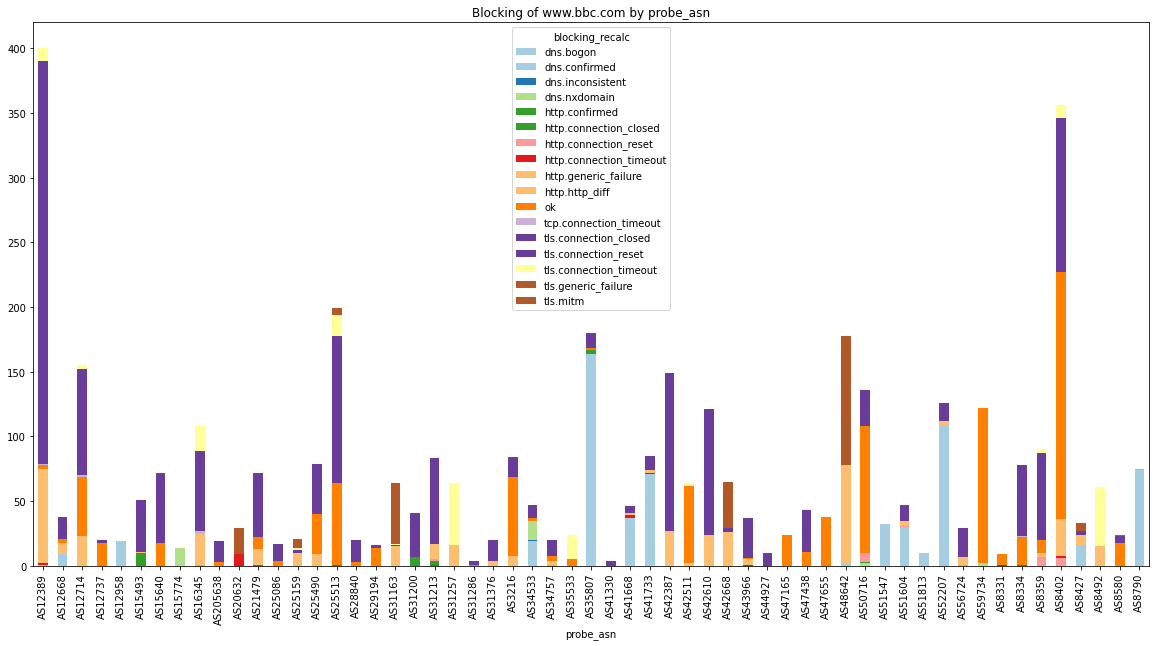

In [59]:
to_plot = df_ru[
    (df_ru['domain'] == 'www.bbc.com')
    & (df_ru['probe_asn'].isin(relevant_asn_domains['probe_asn'].unique()))
    & (df_ru['blocking_recalc'] != 'invalid')
    & (df_ru['measurement_start_time'] > '2022-03-05')
    #& (df_ru['blocking_recalc'] != 'ok')
][['blocking_recalc', 'probe_asn']]
to_plot['count'] = 1
(
    to_plot.pivot_table(
        columns='blocking_recalc',
        index='probe_asn',
        values='count',
        aggfunc='sum'
    ).reset_index()
        .groupby('probe_asn')
        .sum().reset_index()
        .set_index('probe_asn')
        .plot(kind='bar', stacked=True, figsize=(20,10), colormap='Paired', title='Blocking of www.bbc.com by probe_asn')
)

As we can see above, the means through which blocking is implemented across different ISPs varies significantly. In some of them, we can also see that the block is not being implemented at all.

We can use the above chart to navigate our exploration of individual measurements on a per-ISP basis.

In [64]:
def plot_blocking(probe_asn, domain):
    to_plot = df_ru[
        (df_ru['probe_asn'] == probe_asn)
        & (df_ru['domain'] == domain)
        & (df_ru['blocking_recalc'] != 'invalid')
    ][['blocking_recalc', 'measurement_start_time']]
    to_plot['measurement_start_time'] = pd.to_datetime(to_plot['measurement_start_time'])
    to_plot['count'] = 1
    (
    to_plot.pivot_table(
        columns='blocking_recalc',
        index='measurement_start_time',
        values='count',
        aggfunc='sum'
    ).reset_index()
        .groupby(pd.Grouper(key='measurement_start_time', freq='D'))
        .sum().reset_index()
        .set_index('measurement_start_time')
        .plot(kind='bar', stacked=True, title=f"{probe_asn} {domain}", colormap='Paired', figsize=(20,8))
    )

Through the above function, we now have the power to plot a chart that shows us the blocking of a certain domain and ISP over time. In doing so we can determine if the methods through which the blocking is happening are consistent or if there is some variation.

Having a stable signal that doesn't show different ways through which the block is implemented (in cases where the root-cause may be a transient network failure) gives you higher confidence in the data.

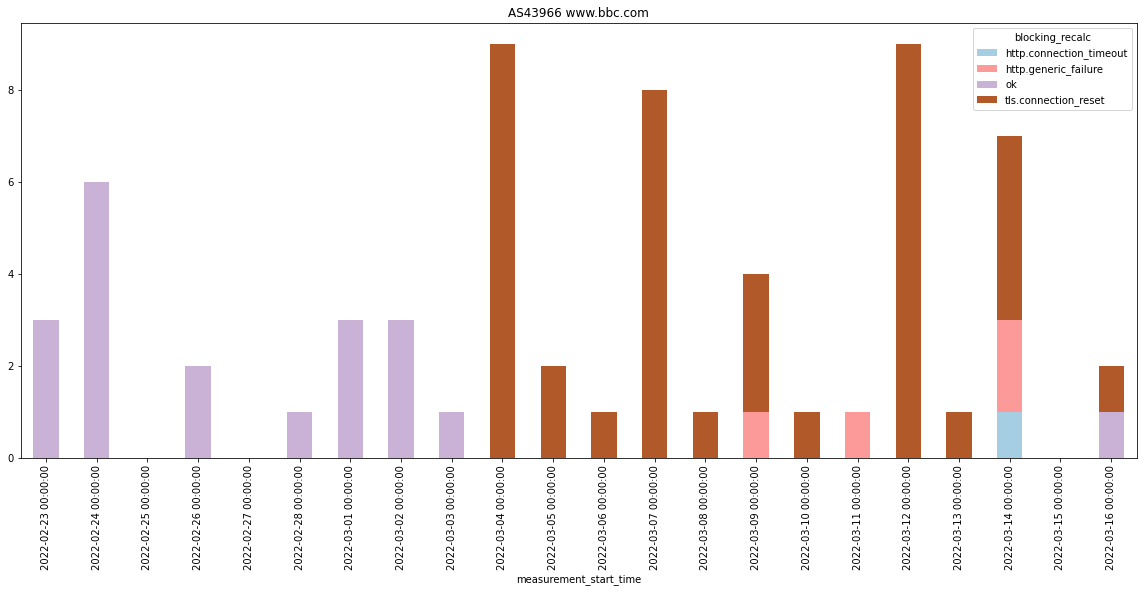

In [65]:
plot_blocking('AS43966', 'www.bbc.com')

Here we can see that the block is happening through a connection reset most of the time. The only outliers are cause by what very likely are old versions of the probe (in many cases you may want to exclude older versions of probes from your analysis, if you have enough data).

The only case that probably deserves further investigation, is the OK measurement on the 16th. Let's find it and open it in OONI Explorer.

In [62]:
df_ru[
    (df_ru['probe_asn'] == 'AS43966')
    & (df_ru['blocking_recalc'] == 'ok')
    & (df_ru['measurement_start_time'].str.startswith('2022-03-16'))
    & (df_ru['domain'] == 'www.bbc.com')
]

,input,measurement_start_time,probe_asn,probe_cc,probe_network_name,report_id,resolver_asn,resolver_ip,resolver_network_name,software_name,...,control_measurement,blocking,http_experiment_failure,dns_experiment_failure,http_title,http_meta_title,http_body_md5,tcp_connect,domain,blocking_recalc
517649,https://www.bbc.com/news/world-51235105,2022-03-16 12:41:20,AS43966,RU,IT REGION LTD,20220316T124100Z_webconnectivity_RU_43966_n1_q...,AS43966,79.173.80.17,IT REGION LTD,ooniprobe-android,...,{'tcp_connect': {'151.101.112.81:443': {'statu...,False,None,None,"Covid map: Coronavirus cases, deaths, vaccinat...","Covid map: Coronavirus cases, deaths, vaccinat...",add8e023428a9d1b4816fb3bb2a238c7,"[{'ip': '151.101.112.81', 'port': 443, 'status...",www.bbc.com,ok


In [63]:
print_explorer_url(df_ru.iloc[517649])

https://explorer.ooni.org/measurement/20220316T124100Z_webconnectivity_RU_43966_n1_qXKPLjBo4r7rzNdl?input=https%3A%2F%2Fwww.bbc.com%2Fnews%2Fworld-51235105


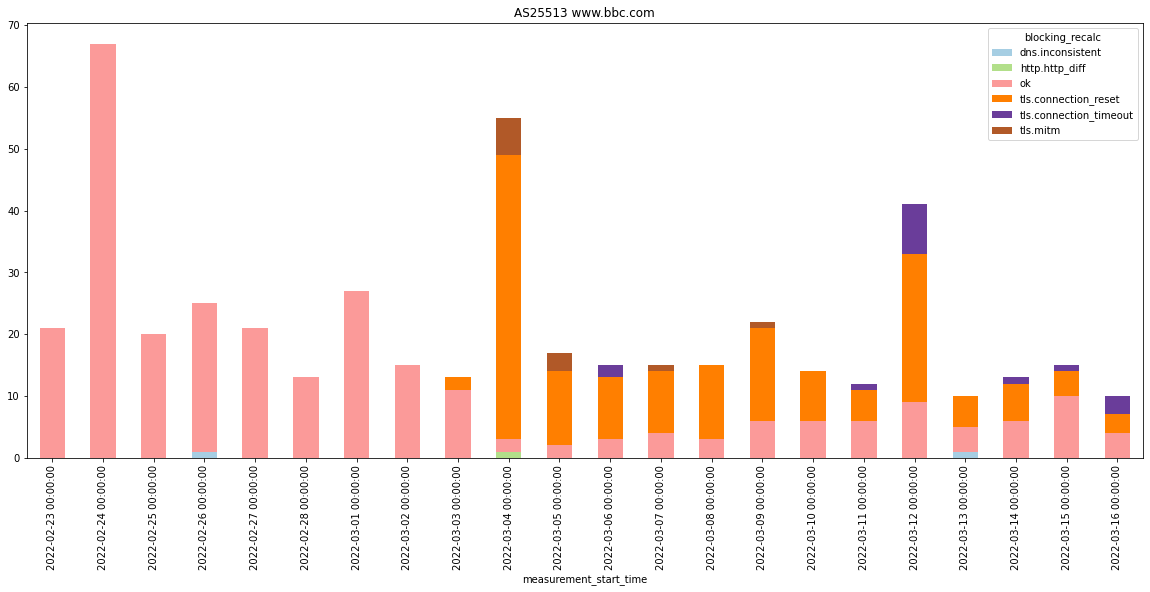

In [66]:
plot_blocking('AS25513', 'www.bbc.com')

In [67]:
df_ru[
    (df_ru['probe_asn'] == 'AS25513')
    & (df_ru['blocking_recalc'] == 'ok')
    & (df_ru['measurement_start_time'].str.startswith('2022-03-11'))
    & (df_ru['domain'] == 'www.bbc.com')
]

,input,measurement_start_time,probe_asn,probe_cc,probe_network_name,report_id,resolver_asn,resolver_ip,resolver_network_name,software_name,...,control_measurement,blocking,http_experiment_failure,dns_experiment_failure,http_title,http_meta_title,http_body_md5,tcp_connect,domain,blocking_recalc
1455010,http://www.bbc.com/news,2022-03-11 22:54:56,AS25513,RU,PJSC Moscow city telephone network,20220311T225300Z_webconnectivity_RU_25513_n1_C...,AS25513,94.29.125.114,PJSC Moscow city telephone network,ooniprobe-android,...,{'tcp_connect': {'151.101.12.81:80': {'status'...,False,None,None,MTC,NaN,a7bad4fa931d233f7e7145dcb6412434,"[{'ip': '151.101.12.81', 'port': 80, 'status':...",www.bbc.com,ok
1465178,http://www.bbc.com/news,2022-03-11 02:32:21,AS25513,RU,PJSC Moscow city telephone network,20220311T021951Z_webconnectivity_RU_25513_n1_F...,AS25513,94.29.125.106,PJSC Moscow city telephone network,ooniprobe-desktop-unattended,...,{'tcp_connect': {'151.101.12.81:80': {'status'...,False,None,None,MTC,NaN,a7bad4fa931d233f7e7145dcb6412434,"[{'ip': '151.101.12.81', 'port': 80, 'status':...",www.bbc.com,ok
1472180,http://www.bbc.com/news,2022-03-11 14:42:04,AS25513,RU,PJSC Moscow city telephone network,20220311T142131Z_webconnectivity_RU_25513_n1_n...,AS59447,45.136.153.146,Istanbuldc Veri Merkezi Ltd Sti,ooniprobe-desktop-unattended,...,{'tcp_connect': {'151.101.12.81:80': {'status'...,False,None,None,MTC,NaN,a7bad4fa931d233f7e7145dcb6412434,"[{'ip': '151.101.12.81', 'port': 80, 'status':...",www.bbc.com,ok
1504898,https://www.bbc.com/news/world-51235105,2022-03-11 07:22:24,AS25513,RU,PJSC Moscow city telephone network,20220311T071246Z_webconnectivity_RU_25513_n1_A...,AS15169,172.217.37.140,Google LLC,ooniprobe-android,...,{'tcp_connect': {'151.101.84.81:443': {'status...,False,None,None,"Covid map: Coronavirus cases, deaths, vaccinat...","Covid map: Coronavirus cases, deaths, vaccinat...",add8e023428a9d1b4816fb3bb2a238c7,"[{'ip': '151.101.84.81', 'port': 443, 'status'...",www.bbc.com,ok
1528928,http://www.bbc.com/news,2022-03-11 08:52:32,AS25513,RU,PJSC Moscow city telephone network,20220311T082127Z_webconnectivity_RU_25513_n1_J...,AS25513,94.29.125.114,PJSC Moscow city telephone network,ooniprobe-desktop-unattended,...,{'tcp_connect': {'151.101.12.81:80': {'status'...,False,None,None,MTC,NaN,a7bad4fa931d233f7e7145dcb6412434,"[{'ip': '151.101.12.81', 'port': 80, 'status':...",www.bbc.com,ok
1554661,https://www.bbc.com/news/world-51235105,2022-03-11 07:18:41,AS25513,RU,PJSC Moscow city telephone network,20220311T071719Z_webconnectivity_RU_25513_n1_3...,AS198806,91.239.98.96,LLC SIBUR,ooniprobe-desktop-unattended,...,{'tcp_connect': {'151.101.112.81:443': {'statu...,False,None,None,"Covid map: Coronavirus cases, deaths, vaccinat...","Covid map: Coronavirus cases, deaths, vaccinat...",add8e023428a9d1b4816fb3bb2a238c7,"[{'ip': '151.101.112.81', 'port': 443, 'status...",www.bbc.com,ok


In [71]:
df_ru[
    (df_ru['probe_asn'] == 'AS25513')
    & (df_ru['blocking_recalc'] == 'ok')
    & (df_ru['measurement_start_time'].str.startswith('2022-03-11'))
    & (df_ru['domain'] == 'www.bbc.com')
]['dns_resolved_ips']

1455010     ['151.101.12.81']
1465178     ['151.101.12.81']
1472180     ['151.101.12.81']
1504898     ['151.101.84.81']
1528928     ['151.101.12.81']
1554661    ['151.101.112.81']
Name: dns_resolved_ips, dtype: object

In two of the OK measurements, it looks like there are different IP addresses returned in the DNS query. Let's inspect the measurement to see if it's a false negative.

In [70]:
print_explorer_url(df_ru.iloc[1504898])

https://explorer.ooni.org/measurement/20220311T071246Z_webconnectivity_RU_25513_n1_A6Ux9DxJ1CkxiLNB?input=https%3A%2F%2Fwww.bbc.com%2Fnews%2Fworld-51235105


Nope, it doesn't look like it. When looking at the blocked metrics, we can see that the IP used is always the "151.101.12.81" one. This means it's quite likely that the blocking by closing the connection through a RST packet is also matching on the endpoint.

In [74]:
df_ru[
    (df_ru['probe_asn'] == 'AS25513')
    & (df_ru['blocking_recalc'] != 'ok')
    & (df_ru['measurement_start_time'].str.startswith('2022-03-11'))
    & (df_ru['domain'] == 'www.bbc.com')
]['dns_resolved_ips']

1435961                                    ['151.101.12.81']
1438061    ['151.101.0.81', '151.101.64.81', '151.101.128...
1471678                                    ['151.101.12.81']
1499181                                    ['151.101.12.81']
1501909                                    ['151.101.12.81']
1531316                                    ['151.101.12.81']
Name: dns_resolved_ips, dtype: object

Let's look at the other potentially false negative measurements

In [75]:
print_explorer_url(df_ru.iloc[1465178])

https://explorer.ooni.org/measurement/20220311T021951Z_webconnectivity_RU_25513_n1_FXsCAbJpZ0dAibqR?input=http%3A%2F%2Fwww.bbc.com%2Fnews


This looks like an actual false negative, which is caused by our blockpage detection heuristics not being good enough.

Let's add this fingerprint to our fingerprint DB and re-annotate the measurements.

In [80]:
df_ru[
    (df_ru['probe_asn'] == 'AS25513')
    & (df_ru['blocking_recalc'] == 'ok')
    & (df_ru['measurement_start_time'].str.startswith('2022-03-11'))
    & (df_ru['domain'] == 'www.bbc.com')
][['http_title', 'http_body_md5']]

,http_title,http_body_md5
1455010,MTC,a7bad4fa931d233f7e7145dcb6412434
1465178,MTC,a7bad4fa931d233f7e7145dcb6412434
1472180,MTC,a7bad4fa931d233f7e7145dcb6412434
1504898,"Covid map: Coronavirus cases, deaths, vaccinat...",add8e023428a9d1b4816fb3bb2a238c7
1528928,MTC,a7bad4fa931d233f7e7145dcb6412434
1554661,"Covid map: Coronavirus cases, deaths, vaccinat...",add8e023428a9d1b4816fb3bb2a238c7


In [81]:
df_ru.loc[(df_ru['http_body_md5'] == 'a7bad4fa931d233f7e7145dcb6412434'), 'blocking_recalc'] = 'http.confirmed'

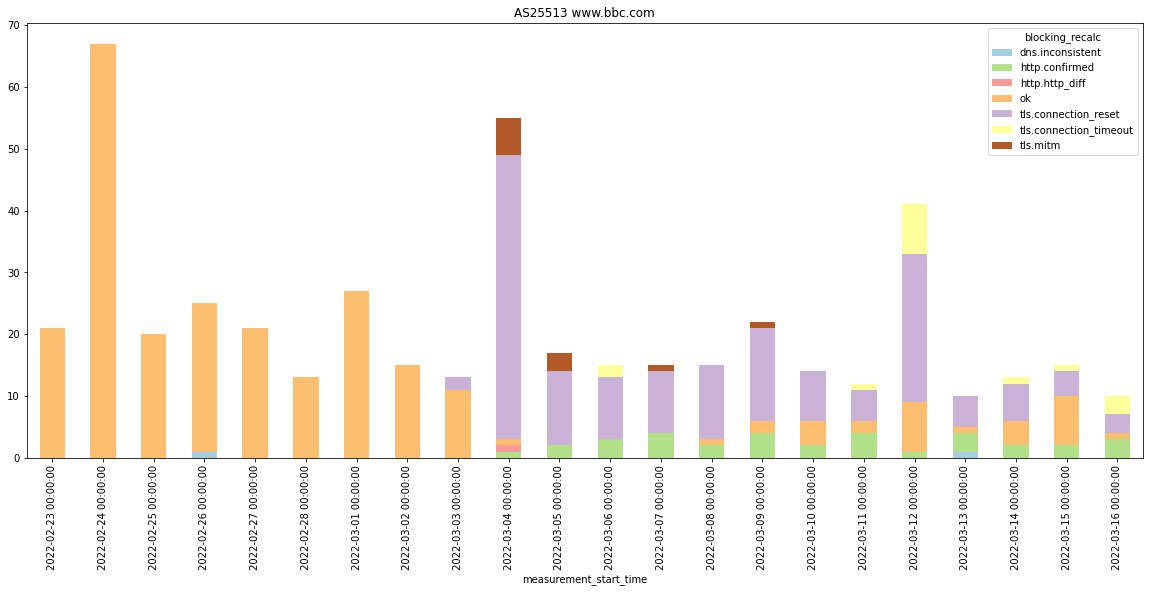

In [82]:
plot_blocking('AS25513', 'www.bbc.com')

In [96]:
data_export = df_ru[
    df_ru['domain'].isin(relevant_domains)
][['domain', 'measurement_start_time', 'probe_asn', 'report_id', 'blocking_recalc']]

In [97]:
data_export['count'] = 1

At this point we would iterate the process of filtering out any additional false positives and false negatives, until we feel quite confident that we have eliminated most of the outliers (or come up with an explaination as to why we are seeing them).

Once this process is done, it might be desirable to create a CSV export of this cleaned data in preparation for publication ready charts (ex. through tools like Tableau).

Since charting tools generally work best with data where the values you need to plot are in the cells and the columns indicate the category of the value, we will reshape the data using the `pivot_table` function. This basically takes the values of `blocking_recalc` and puts them as columns, the value of the cells, in this case, is always going to be one. It's generally quite easy to do further aggregation and grouping inside of the charting tool itself.

In [102]:
data_export.pivot_table(
    index=['probe_asn', 'domain', 'measurement_start_time', 'report_id'], 
    columns=['blocking_recalc'], 
    values='count'
).reset_index().to_csv('20220226-20220317-russia-relevant-sites-pivot.csv')

In [103]:
!wc -l 20220226-20220317-russia-relevant-sites-pivot.csv

66335 20220226-20220317-russia-relevant-sites-pivot.csv
